In [1]:
#!pip install pyproj
#!pip install request

# Proceso de desarrollo 

## Preparar la BD para la transformacion

**Realizar este análisis por elemento (index)**

- Cargar la BD
- Cargar el dict
- Revisar la existencia de  verbatimLatitude y verbatimLongitude.
    - En caso de existir, revisar si existe verbatimCoordinates, si no está se debe crear.
    - Si ya está verbatimCoordinates creado pasar.
    - En caso de existir y estar vacio completar datos por verbatimCoordinates.
    - En caso de no existir (verbatimLatitude y verbatimLongitude)crear mediante verbatimCoordinates.

- Revisar la existencia de verbatimCoordinateSystem.
    - En caso de existir.
        - Si el elemento esta vacio, verificar que si existe una T en el string es una UTM, si no hay T dms.
    - En caso de no existir, crearla considerando el criterio anterior.

- Revisar la existencia de country.
    - En caso de no existir, solo transformar dms y saltar UTM.
    - En caso de existir:
        - agregar el campo countryCode
        - En caso de existir y no hacer el match en el diccionario saltar la transformacion de UTM y solo dms

## Realizar la transformación

- Realizar la transformación mediante las API


    
    

- La base de datos debe tener los siguientes campos llenos de manera obligatorioa.
    - verbatimCoordinates (desde esté campo se hará la transformación).
    - verbatimCoordinateSystem
    - country
    

In [17]:
from pyproj import Proj #no se está usando por el momento
import utm
import requests
import json
import pandas as pd
import numpy as np
import math
import re
from geopy.geocoders import Nominatim #FASTER than api



pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199

country_data=pd.read_csv("https://raw.githubusercontent.com/VertNet/DwCVocabs/master/vocabs/countryCode_country_continent_merged.csv")
country_data.set_index("country",inplace=True)
country_data_dict=country_data.to_dict()

In [29]:
class db_prep:
    def __init__(self,data):
        self.data=data
    
    def verbatimCoordinates_dms_sep(self,index):
        for Coordinate in self.data.loc[index,"verbatimCoordinates"].split(","):
            if "N" in Coordinate.upper(): 
                self.data.loc[index,"verbatimLatitude"]=Coordinate
            elif "S" in Coordinate.upper(): 
                self.data.loc[index,"verbatimLatitude"]=Coordinate
            elif "E" in Coordinate.upper(): 
                self.data.loc[index,"verbatimLongitude"]=Coordinate
            elif "W" or "O" in Coordinate.upper(): 
                self.data.loc[index,"verbatimLongitude"]=Coordinate

    
    def verbatimCoordinates_utm_sep(self,index):
        Coordinate= self.data.loc[index,"verbatimCoordinates"].split(" ")
        for elements in coordinate:
            if "N" or "S" in elements.upper(): timezone_index=coordinate.index(elements)
        Coordinate_indexes=list(range(0,len(Coordinate)))
        Coordinate_indexes.remove(timezone_index)
        if int(Coordinate[Coordinate_indexes[0]]) > int(Coordinate[Coordinate_indexes[1]]):
            self.data.loc[index,"verbatimLatitude"]=Coordinate[Coordinate_indexes[1]]
            self.data.loc[index,"verbatimLongitude"]=Coordinate[Coordinate_indexes[0]]
        else:
            self.data.loc[index,"verbatimLatitude"]=Coordinate[0]
            self.data.loc[index,"verbatimLongitude"]=Coordinate[1]
    
    def verb_lat_long_autocomplete(self):
        if set(['verbatimLatitude', 'verbatimLongitude']).issubset(set(self.data.columns.to_list())) is False:
            verb_coord_position=self.data.columns.to_list().index("verbatimCoordinates")+1
            self.data.insert(verb_coord_position,"verbatimLatitude",np.nan)
            self.data.insert(verb_coord_position+1,"verbatimLongitude",np.nan)
            for index in self.data.index:
                if self.data.loc[index,"verbatimCoordinates"] is np.nan:
                    pass
                elif isinstance(self.data.loc[index,"verbatimLongitude"],str)==False and isinstance(self.data.loc[index,"verbatimLatitude"],str)==False:  #cambio
                    if (np.isnan(self.data.loc[index,"verbatimLongitude"])) or (np.isnan(self.data.loc[index,"verbatimLatitude"])): #cambio
                        if self.data.loc[index,"verbatimCoordinateSystem"]=="UTM":
                            self.verbatimCoordinates_utm_sep()
                        elif self.data.loc[index,"verbatimCoordinateSystem"]=="degrees minutes seconds":
                                self.verbatimCoordinates_dms_sep()
                        else:
                            pass                    
        if set(['verbatimLatitude', 'verbatimLongitude']).issubset(set(self.data.columns.to_list())) is True:
            for index in self.data.index:
                if self.data.loc[index,"verbatimCoordinates"] is np.nan:
                    pass
                elif isinstance(self.data.loc[index,"verbatimLongitude"],str)==False and isinstance(self.data.loc[index,"verbatimLatitude"],str)==False:  #cambio
                    if (np.isnan(self.data.loc[index,"verbatimLongitude"])) or (np.isnan(self.data.loc[index,"verbatimLatitude"])): #cambio
                        if self.data.loc[index,"verbatimCoordinateSystem"]=="UTM":
                            self.verbatimCoordinates_utm_sep(index)
                        elif self.data.loc[index,"verbatimCoordinateSystem"]=="degrees minutes seconds":
                            self.verbatimCoordinates_dms_sep(index)
                        else:
                            pass
                        
    
    def continent_autocomplete(self):
        country_data=pd.read_csv("https://raw.githubusercontent.com/VertNet/DwCVocabs/master/vocabs/countryCode_country_continent_merged.csv")
        country_data.set_index("country",inplace=True)
        country_data_dict=country_data.to_dict()
        if set(['country']).issubset(set(self.data.columns.to_list())) is True:
            if set(['continent']).issubset(set(self.data.columns.to_list())) is True:
                for index in self.data.index:
                    if self.data.loc[index,"country"] in country_data_dict["continent"].keys() and self.data.loc[index,"continent"] is np.nan:
                        self.data.loc[index,"continent"]=country_data_dict["continent"][self.data.loc[index,"country"]]
                    else: pass        
            elif set(['continent']).issubset(set(self.data.columns.to_list())) is False:
                self.data.insert(self.data.columns.to_list().index("country")-1,"continent",np.nan) #en que lugar lo coloco
                for index in self.data.index:
                    if self.data.loc[index,"country"] in country_data_dict["continent"].keys():
                        self.data.loc[index,"continent"]=country_data_dict["continent"][self.data.loc[index,"country"]]
                    else: pass  
        else: pass 
    
    def location_autocomplete(self): #include country, country_code, stateProvince, county, municipality 
        geolocator = Nominatim(user_agent="GeoParser")
        for index in self.data.index:
            try:
                lat=self.data.loc[index,"decimalLatitude"]
                lon=self.data.loc[index,"decimalLongitude"]
                location=geolocator.reverse(f"{lat},{lon}")
                self.data.loc[index,"country"]=location.raw["address"]["country"]
                #if self.data.loc[index,"georeferenceSources"] == "GeoParser Marcelo Oyaneder | Canadensys":
                #    self.data.loc[index,"georeferenceSources"]="GeoParser Marcelo Oyaneder | GeoPy | Canadensys"
                #else: self.data.loc[index,"georeferenceSources"]="GeoParser Marcelo Oyaneder | GeoPy"
                #if set(['locality']).issubset(set(self.data.columns.to_list())) is True and np.isnan(self.data.loc[index,"locality"]):
                #    self.data.loc[index,"locality"]= location.raw["display_name"]
                #elif set(['locality']).issubset(set(self.data.columns.to_list())) is False:
                #    self.data["locality"]=np.nan
                #    self.data.loc[index,"locality"]= location.raw["display_name"]
                self.data.loc[index,"countryCode"]=location.raw["address"]["country_code"].upper()
                self.data.loc[index,"stateProvince"]=location.raw["address"]["state"]
                self.data.loc[index,"county"]=location.raw["address"]["county"]
                if list(location.raw["address"].values())[-5] != location.raw["address"]["county"]:
                    self.data.loc[index,"municipality"]=list(location.raw["address"].values())[-5]
            except: pass
        
    def higherGeography_autocomplete(self): 
        dwc_labels=["continent","waterBody","country","stateProvince","county","municipality","islandGroup","island"]
        dwc_labels_selected=[i for i in dwc_labels if i in self.data.columns]
        try:
            for index in self.data.index:
                higherGeography_list=[]
                if self.data.loc[index,"higherGeography"] is not np.nan:
                    for elements in dwc_labels_selected:
                        if isinstance(self.data.loc[index,elements], str): higherGeography_list.append(self.data.loc[index,elements])
                higherGeography_str=" | ".join(higherGeography_list)
                self.data.loc[index,"higherGeography"]=higherGeography_str         
        except KeyError:
            self.data["higherGeography"]=np.nan
            for index in self.data.index:
                higherGeography_list=[]
                if self.data.loc[index,"higherGeography"] is not np.nan:
                    for elements in dwc_labels_selected:
                        if isinstance(self.data.loc[index,elements], str): higherGeography_list.append(self.data.loc[index,elements])
                higherGeography_str=" | ".join(higherGeography_list)
                self.data.loc[index,"higherGeography"]=higherGeography_str      
    
    def verbatimCoordinates_autocomplete(self):
        if "verbatimCoordinates" not in self.data.columns:
            if "verbatimLatitude" and "verbatimLongitude" in self.data.columns:
                self.data["verbatimCoordinates"]=np.nan
                for index in self.data.index:
                    if self.data.loc[index,"verbatimLatitude"] and self.data.loc[index,"verbatimLongitude"] is not np.nan:
                        lat,lon=self.data.loc[index,"verbatimLatitude"],self.data.loc[index,"verbatimLongitude"]
                        self.data.loc[index,"verbatimCoordinates"]=f"{lat}, {lon}"
                    elif self.data.loc[index,"decimalLatitude"] and self.data.loc[index,"decimalLongitude"] is not np.nan:
                        lat,lon=self.data.loc[index,"decimalLatitude"],self.data.loc[index,"decimalLongitude"]
                        self.data.loc[index,"verbatimCoordinates"]=f"{lat}, {lon}"
                    else :pass 
        if "verbatimCoordinates" in self.data.columns:
            for index in self.data.index:
                if self.data.loc[index,"verbatimCoordinates"] is np.nan:
                    if self.data.loc[index,"verbatimLatitude"] and self.data.loc[index,"verbatimLongitude"] is not np.nan:
                        lat,lon=self.data.loc[index,"verbatimLatitude"],self.data.loc[index,"verbatimLongitude"]
                        self.data.loc[index,"verbatimCoordinates"]=f"{lat}, {lon}"
                    else: pass
                      
    def verbatimCoordinateSystem_autocomplete(self): #work in progress
        minutes="'"
        seconds='"'
        for index in self.data.index:
            try:
                if "°" or "d" in self.data.loc[index,"verbatimCoordinates"]: 
                    if minutes and seconds in self.data.loc[index,"verbatimCoordinates"]: self.data.loc[index,"verbatimCoordinateSystem"]="degrees minutes seconds"
                    elif minutes in self.data.loc[index,"verbatimCoordinates"]: self.data.loc[index,"verbatimCoordinateSystem"]="degrees decimal minutes"
                elif "." in self.data.loc[index,"verbatimCoordinates"]: self.data.loc[index,"verbatimCoordinateSystem"]="decimal degrees"
                else: self.data.loc[index,"verbatimCoordinateSystem"]="UTM"
            except: pass
    
    def coordinatePrecision_autocomplete(self):
        for index in self.data.index:
            if (self.data.loc[index,"verbatimLatitude"] or self.data.loc[index,"verbatiLongitude"]) is np.nan or self.data.loc[index,"verbatimCoordinateSystem"]=="decimal degrees":
                if (self.data.loc[index,"decimalLatitude"] or self.data.loc[index,"decimalLongitude"]) is not np.nan:
                    try:
                        lat=self.data.loc[index,"decimalLatitude"].split(".")
                        lon=self.data.loc[index,"decimalLongitude"].split(".")
                        self.data.loc[index,"coordinatePrecision"]="0."+"0"*(min(len(lat[1]),len(lon[1]))-1)+"1"
                    except: pass
            if self.data.loc[index,"verbatimCoordinateSystem"]=="degrees minutes seconds":
                try:
                    lat=self.data.loc[index,"verbatimLatitude"]
                    lon=self.data.loc[index,"verbatimLongitude"]
                    srch="'(.+?)\""
                    m_lat=re.search(srch, lat)
                    m_lon=re.search(srch, lon)
                    found_lat=m_lat.group(1)
                    found_lon=m_lon.group(1)
                    if "." in found_lat: 
                        pres=1/pow(10,len(found_lat.split(".")[1]))
                        coordP_lat=pres/3600.
                    else: coordP_lat=1/3600.
                    if "." in found_lon:
                        pres=1/pow(10,len(found_lon.split(".")[1]))
                        coordP_lon=pres/3600.
                    else: coordP_lon=1/3600.
                    self.data.loc[index,"coordinatePrecision"]='{:.7f}'.format(min(coordP_lon,coordP_lat))
                except: pass
            if self.data.loc[index,"verbatimCoordinateSystem"]=="degrees decimal minutes":
                try:
                    lat=self.data.loc[index,"verbatimLatitude"]
                    lon=self.data.loc[index,"verbatimLongitude"]
                    srch="°(.+?)\'"
                    m_lat=re.search(srch, lat)
                    m_lon=re.search(srch, lon)
                    found_lat=m_lat.group(1)
                    found_lon=m_lon.group(1)
                    if "." in found_lat: 
                        pres=1/pow(10,len(found_lat.split(".")[1]))
                        coordP_lat=pres/60.
                    else: coordP_lat=1/60.
                    if "." in found_lon:
                        pres=1/pow(10,len(found_lon.split(".")[1]))
                        coordP_lon=pres/60.
                    else: coordP_lon=1/60.
                    self.data.loc[index,"coordinatePrecision"]='{:.7f}'.format(min(coordP_lon,coordP_lat))
                except: pass

                

In [19]:
class coord_transform:
    def __init__(self,data):
        self.data=data
    
    def utm_to_dg(self):
        for index in self.data.index:
            if self.data.loc[index,"verbatimCoordinates"] is not np.nan and self.data.loc[index,"verbatimCoordinateSystem"]=="UTM":
                coordinate= self.data.loc[index,"verbatimCoordinates"].split(" ")
                for elements in coordinate:
                    if "N" in elements.upper(): 
                        zone_index=coordinate.index(elements)
                        Global="North"
                    elif "S" in elements.upper():
                        zone_index=coordinate.index(elements)
                        Global="South"
                if Global=="South":
                    lat,lon=utm.to_latlon(self.data.loc[index,"verbatimLatitude"], self.data.loc[index,"verbatimLongitude"], int(coordinate[zone_index].upper().replace("S","")), northern=False)
                elif Global=="North":
                    lat,lon=utm.to_latlon(self.data.loc[index,"verbatimLatitude"], self.data.loc[index,"verbatimLongitude"], int(coordinate[zone_index].upper().replace("N","")), northern=True)
                self.data.loc[index,"decimalLatitude"]="{0:.7f}".format(lat)
                self.data.loc[index,"decimalLongitude"]="{0:.7f}".format(lon)
                self.data.loc[index,"geodeticDatum"]="WGS84"
                #self.data.loc[index,"georeferenceSources"]="GeoParser Marcelo Oyaneder"
    
    def dms_to_dg(self):
        for index in self.data.index:
            if self.data.loc[index,"verbatimCoordinateSystem"]=="degrees minutes seconds" and self.data.loc[index,"verbatimCoordinates"] is not np.nan:
                try: 
                    location= self.data.loc[index,"verbatimCoordinates"]
                    if "O" in location.upper():
                        location=location.replace("O","W")
                    response=requests.get(f"http://data.canadensys.net/tools/coordinates.json?data=35|{location}&idprovided=TRUE").json()
                    lon,lat=response["features"][0]["geometry"]["coordinates"]
                    self.data.loc[index,"decimalLatitude"]="{0:.7f}".format(lat)
                    self.data.loc[index,"decimalLongitude"]="{0:.7f}".format(lon)
                    self.data.loc[index,"geodeticDatum"]="WGS84"
                    #self.data.loc[index,"georeferenceSources"]="GeoParser Marcelo Oyaneder | Canadensys"
                except:
                    self.data.loc[index,"decimalLatitude"]="Error"
                    self.data.loc[index,"decimalLongitude"]="Error"

                            

# TESTING...

In [20]:
data=pd.read_excel("coordenadas_SQF.xlsx")

data

occurrenceID  verbatimCoordinates verbatimLatitude  \
0       PBUCH:SQF:2955                  NaN              NaN   
1       PBUCH:SQF:3782                  NaN              NaN   
2       PBUCH:SQF:3783                  NaN              NaN   
3       PBUCH:SQF:3784                  NaN              NaN   
4       PBUCH:SQF:3785                  NaN              NaN   
5       PBUCH:SQF:3786                  NaN              NaN   
6       PBUCH:SQF:3789                  NaN              NaN   
7       PBUCH:SQF:3790                  NaN              NaN   
8       PBUCH:SQF:3791                  NaN              NaN   
9     PBUCH:SQF:3791H1                  NaN              NaN   
10      PBUCH:SQF:3792                  NaN              NaN   
11      PBUCH:SQF:3793                  NaN              NaN   
12      PBUCH:SQF:3796                  NaN              NaN   
13      PBUCH:SQF:3798                  NaN              NaN   
14      PBUCH:SQF:3799                  NaN              NaN   
15      PBUCH:SQF:3800                  NaN              NaN   
16      PBUCH:SQF:3802                  NaN              NaN   
17      PBUCH:SQF:3804                  NaN              NaN   
18      PBUCH:SQF:3805                  NaN              NaN   
19    PBUCH:SQF:3805H1                  NaN              NaN   
20      PBUCH:SQF:3807                  NaN              NaN   
21    PBUCH:SQF:3807H1                  NaN              NaN   
22      PBUCH:SQF:3808                  NaN              NaN   
23      PBUCH:SQF:3809                  NaN              NaN   
24      PBUCH:SQF:3810                  NaN              NaN   
25      PBUCH:SQF:3811                  NaN              NaN   
26      PBUCH:SQF:3812                  NaN              NaN   
27      PBUCH:SQF:3813                  NaN              NaN   
28    PBUCH:SQF:3813H1                  NaN              NaN   
29      PBUCH:SQF:3814                  NaN              NaN   
30      PBUCH:SQF:3815                  NaN              NaN   
31      PBUCH:SQF:3816                  NaN              NaN   
32      PBUCH:SQF:3817                  NaN              NaN   
33    PBUCH:SQF:3817H1                  NaN              NaN   
34      PBUCH:SQF:3818                  NaN              NaN   
35    PBUCH:SQF:3818H1                  NaN              NaN   
36      PBUCH:SQF:3821                  NaN              NaN   
37      PBUCH:SQF:3822                  NaN              NaN   
38    PBUCH:SQF:3822H1                  NaN              NaN   
39      PBUCH:SQF:3823                  NaN              NaN   
40      PBUCH:SQF:3824                  NaN              NaN   
41      PBUCH:SQF:3825                  NaN              NaN   
42      PBUCH:SQF:3826                  NaN              NaN   
43      PBUCH:SQF:3827                  NaN              NaN   
44      PBUCH:SQF:3828                  NaN              NaN   
45      PBUCH:SQF:3829                  NaN              NaN   
46      PBUCH:SQF:3830                  NaN              NaN   
47      PBUCH:SQF:3831                  NaN              NaN   
48      PBUCH:SQF:3832                  NaN              NaN   
49      PBUCH:SQF:3833                  NaN              NaN   
50      PBUCH:SQF:3837                  NaN              NaN   
51    PBUCH:SQF:3837H1                  NaN              NaN   
52      PBUCH:SQF:3838                  NaN              NaN   
53      PBUCH:SQF:3839                  NaN              NaN   
54      PBUCH:SQF:3840                  NaN              NaN   
55      PBUCH:SQF:3842                  NaN              NaN   
56      PBUCH:SQF:3843                  NaN              NaN   
57      PBUCH:SQF:3844                  NaN              NaN   
58      PBUCH:SQF:3845                  NaN              NaN   
59      PBUCH:SQF:3846                  NaN              NaN   
60    PBUCH:SQF:3846H1                  NaN              NaN   
61      PBUCH:SQF:3847                  Na

In [30]:
%%time
#Testing...

db_prep(data).verbatimCoordinates_autocomplete()
db_prep(data).verb_lat_long_autocomplete()
db_prep(data).verbatimCoordinateSystem_autocomplete()
db_prep(data).coordinatePrecision_autocomplete()
coord_transform(data).utm_to_dg()
coord_transform(data).dms_to_dg()


Wall time: 1.95 s


In [7]:
%%time
# Testing ...

db_prep(data).location_autocomplete()
db_prep(data).continent_autocomplete()
db_prep(data).higherGeography_autocomplete()

Wall time: 18min 19s


In [31]:
data

occurrenceID  verbatimCoordinates verbatimLatitude  \
0       PBUCH:SQF:2955                  NaN              NaN   
1       PBUCH:SQF:3782                  NaN              NaN   
2       PBUCH:SQF:3783                  NaN              NaN   
3       PBUCH:SQF:3784                  NaN              NaN   
4       PBUCH:SQF:3785                  NaN              NaN   
5       PBUCH:SQF:3786                  NaN              NaN   
6       PBUCH:SQF:3789                  NaN              NaN   
7       PBUCH:SQF:3790                  NaN              NaN   
8       PBUCH:SQF:3791                  NaN              NaN   
9     PBUCH:SQF:3791H1                  NaN              NaN   
10      PBUCH:SQF:3792                  NaN              NaN   
11      PBUCH:SQF:3793                  NaN              NaN   
12      PBUCH:SQF:3796                  NaN              NaN   
13      PBUCH:SQF:3798                  NaN              NaN   
14      PBUCH:SQF:3799                  NaN              NaN   
15      PBUCH:SQF:3800                  NaN              NaN   
16      PBUCH:SQF:3802                  NaN              NaN   
17      PBUCH:SQF:3804                  NaN              NaN   
18      PBUCH:SQF:3805                  NaN              NaN   
19    PBUCH:SQF:3805H1                  NaN              NaN   
20      PBUCH:SQF:3807                  NaN              NaN   
21    PBUCH:SQF:3807H1                  NaN              NaN   
22      PBUCH:SQF:3808                  NaN              NaN   
23      PBUCH:SQF:3809                  NaN              NaN   
24      PBUCH:SQF:3810                  NaN              NaN   
25      PBUCH:SQF:3811                  NaN              NaN   
26      PBUCH:SQF:3812                  NaN              NaN   
27      PBUCH:SQF:3813                  NaN              NaN   
28    PBUCH:SQF:3813H1                  NaN              NaN   
29      PBUCH:SQF:3814                  NaN              NaN   
30      PBUCH:SQF:3815                  NaN              NaN   
31      PBUCH:SQF:3816                  NaN              NaN   
32      PBUCH:SQF:3817                  NaN              NaN   
33    PBUCH:SQF:3817H1                  NaN              NaN   
34      PBUCH:SQF:3818                  NaN              NaN   
35    PBUCH:SQF:3818H1                  NaN              NaN   
36      PBUCH:SQF:3821                  NaN              NaN   
37      PBUCH:SQF:3822                  NaN              NaN   
38    PBUCH:SQF:3822H1                  NaN              NaN   
39      PBUCH:SQF:3823                  NaN              NaN   
40      PBUCH:SQF:3824                  NaN              NaN   
41      PBUCH:SQF:3825                  NaN              NaN   
42      PBUCH:SQF:3826                  NaN              NaN   
43      PBUCH:SQF:3827                  NaN              NaN   
44      PBUCH:SQF:3828                  NaN              NaN   
45      PBUCH:SQF:3829                  NaN              NaN   
46      PBUCH:SQF:3830                  NaN              NaN   
47      PBUCH:SQF:3831                  NaN              NaN   
48      PBUCH:SQF:3832                  NaN              NaN   
49      PBUCH:SQF:3833                  NaN              NaN   
50      PBUCH:SQF:3837                  NaN              NaN   
51    PBUCH:SQF:3837H1                  NaN              NaN   
52      PBUCH:SQF:3838                  NaN              NaN   
53      PBUCH:SQF:3839                  NaN              NaN   
54      PBUCH:SQF:3840                  NaN              NaN   
55      PBUCH:SQF:3842                  NaN              NaN   
56      PBUCH:SQF:3843                  NaN              NaN   
57      PBUCH:SQF:3844                  NaN              NaN   
58      PBUCH:SQF:3845                  NaN              NaN   
59      PBUCH:SQF:3846                  NaN              NaN   
60    PBUCH:SQF:3846H1                  NaN              NaN   
61      PBUCH:SQF:3847                  Na

In [9]:
#data.to_excel("coordenadas_SQF_result.xlsx",index=False)


%time
location="32° 46'S, 71° 32'W"
response=requests.get(f"http://data.canadensys.net/tools/coordinates.json?data=35|{location}&idprovided=TRUE")
test=response.json()
test["features"][0]["geometry"]["coordinates"]

# Find Country Test

%time
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="GeoParser")
location = geolocator.reverse("-32.7667, -71.5333")
location.raw



geolocator = Nominatim(user_agent="GeoParser")
lat=data.loc[20,"decimalLatitude"]
lon=data.loc[20,"decimalLongitude"]
location=geolocator.reverse(f"{lat},{lon}")
location.raw["display_name"]

In [9]:
import requests

result=requests.get(f"https://api.gbif-uat.org/v1/geocode/reverse?lat=-33.2167&lng=-70.7833").json()
result

[{'id': 'CHL.14_1',
  'type': 'GADM1',
  'source': 'http://gadm.org/',
  'title': 'Región Metropolitana de Santiago',
  'isoCountryCode2Digit': 'CL',
  'distance': 0.0},
 {'id': 'CL',
  'type': 'Political',
  'source': 'http://www.naturalearthdata.com/',
  'title': 'Chile',
  'isoCountryCode2Digit': 'CL',
  'distance': 0.0},
 {'id': 'CHL',
  'type': 'GADM0',
  'source': 'http://gadm.org/',
  'title': 'Chile',
  'isoCountryCode2Digit': 'CL',
  'distance': 0.0},
 {'id': 'WGSRPD:CLC-SA',
  'type': 'WGSRPD',
  'source': 'http://www.tdwg.org/standards/109',
  'title': 'Santiago',
  'isoCountryCode2Digit': 'CL',
  'distance': 0.0},
 {'id': 'CHL.14.1.1_1',
  'type': 'GADM3',
  'source': 'http://gadm.org/',
  'title': 'Colina',
  'isoCountryCode2Digit': 'CL',
  'distance': 0.0},
 {'id': 'CHL.14.1_1',
  'type': 'GADM2',
  'source': 'http://gadm.org/',
  'title': 'Chacabuco',
  'isoCountryCode2Digit': 'CL',
  'distance': 0.0}]

In [8]:
import requests

lat,lon=-33.2167, -70.7833
result=requests.get(f"https://nominatim.openstreetmap.org/reverse?format=json&lat={lat}&lon={lon}&polygon_text=1").json()
result

{'place_id': 105508001,
 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright',
 'osm_type': 'way',
 'osm_id': 86232684,
 'lat': '-33.21450801750742',
 'lon': '-70.78341229081299',
 'display_name': 'Santa Carolina, Coquimbo, Lampa, Provincia de Chacabuco, Región Metropolitana de Santiago, 93800, Chile',
 'address': {'road': 'Santa Carolina',
  'hamlet': 'Coquimbo',
  'town': 'Lampa',
  'county': 'Provincia de Chacabuco',
  'state': 'Región Metropolitana de Santiago',
  'postcode': '93800',
  'country': 'Chile',
  'country_code': 'cl'},
 'boundingbox': ['-33.2149045', '-33.2143356', '-70.7911759', '-70.7800466'],
 'geotext': 'LINESTRING(-70.7911759 -33.2149045,-70.7901847 -33.2148497,-70.7871209 -33.214695,-70.7867521 -33.2146823,-70.7856412 -33.2146222,-70.7800466 -33.2143356)'}

In [5]:
polygon1=result["geotext"]
polygon1

'POLYGON((-70.8260488 -33.7488354,-70.8249244 -33.7513528,-70.8209955 -33.7540753,-70.8179979 -33.7528818,-70.8164358 -33.7514545,-70.8143716 -33.7509817,-70.8137901 -33.7501717,-70.813627 -33.7491137,-70.8124468 -33.7470887,-70.812155 -33.7452813,-70.8123438 -33.7445212,-70.8124168 -33.7427012,-70.8124532 -33.7408313,-70.8121722 -33.7395501,-70.8115606 -33.737962,-70.810404 -33.7365131,-70.8088484 -33.735173,-70.8076896 -33.7342808,-70.8060524 -33.7335937,-70.8046705 -33.7331869,-70.8030591 -33.7335045,-70.8019261 -33.7333475,-70.8010185 -33.7325534,-70.8002009 -33.7318039,-70.7988791 -33.7310258,-70.7976174 -33.7309348,-70.7963342 -33.7309973,-70.7953944 -33.7305868,-70.7938709 -33.7295,-70.7928817 -33.7288915,-70.7920964 -33.7280331,-70.7910042 -33.7274478,-70.7881138 -33.7243425,-70.7867598 -33.722772,-70.7850303 -33.7213281,-70.7830004 -33.7200645,-70.7816872 -33.7182994,-70.7810006 -33.7181173,-70.780256 -33.7170304,-70.7785673 -33.7163503,-70.7765374 -33.7159059,-70.7743852 -33.

In [12]:
from shapely.wkt import loads as load_wkt
p1 = load_wkt(polygon1)

print(p1.centroid.wkt) 
# POINT ( -33.5922859,-70.7045838 )

POINT (-70.72398836846563 -33.62911928526961)


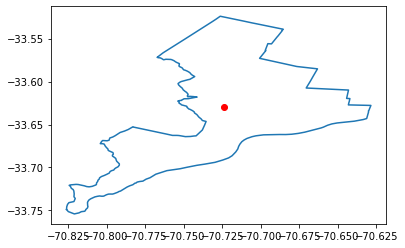

In [13]:
import matplotlib.pyplot as plt
plt.plot(*p1.exterior.xy)
plt.plot(-70.72398836846563,-33.62911928526961,"ro") 

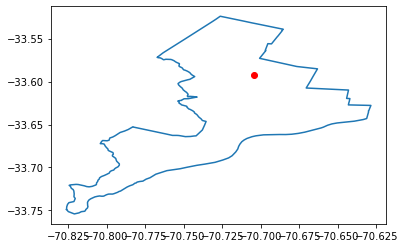

In [14]:
plt.plot(*p1.exterior.xy)
plt.plot(-70.7045838,-33.5922859,"ro") 

In [59]:
import re

In [84]:
s="69°02'W "
re.search("° (.+?)'", s)

In [81]:
start = s.find('°')+1
end = s.find("'", start)
s[start:end]

'02'

In [7]:
import re

text ="121d 10' 34.785\" W"

srch="'(.+?)\""
m = re.search(srch, text)
if m:
    found = m.group(1)

In [8]:
len(found.split(".")[1])

3

In [13]:
pres=1/pow(10,3)

In [26]:
inte='{:.7f}'.format(pres/3600.)

In [28]:
float(inte)

3e-07